<a href="https://colab.research.google.com/github/shashankvmaiya/Movie-Genre-Multi-Label-Text-Classification/blob/master/Reports/Sentence_Encoder_Playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summary

This notebook is essentially the playground where I try out various Sentence Encoders/Embedding techniques that I find online on different websites 

In [0]:
!pip3 install --quiet "tensorflow>=1.7"
!pip3 install --quiet tensorflow-hub

In [0]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import os.path
import math
import scipy
from sklearn.decomposition import PCA

import tensorflow as tf
import tensorflow_hub as hub

sns.set_style("whitegrid")
sns.set_context("talk", font_scale=0.8)

# Universal Sentence Encoder
In this section, we will learn a tool called Universal Sentence Encoder by Google that allows you to convert any sentence into a vector. The best sentence encoders available right now are the two Universal Sentence Encoder models by Google. One of them is based on a Transformer architecture and the other one is based on Deep Averaging Network (DAN). 

Transformer Model : https://tfhub.dev/google/universal-sentence-encoder-large/3  
DAN Model : https://tfhub.dev/google/universal-sentence-encoder/2

They are pre-trained on a large corpus and can be used in a variety of tasks (sentimental analysis, classification and so on). Both models take a word, sentence or a paragraph as input and output a 512-dimensional vector. The transformer model is designed for higher accuracy, but the encoding requires more memory and computational time. The DAN model on the other hand is designed for speed and efficiency, and some accuracy is sacrificed.

Most of the below code is obtained from [tfhub_notebook](https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/semantic_similarity_with_tf_hub_universal_encoder.ipynb).   

For more information on Universal Sentence Encoder, refer [link text](https://blog.floydhub.com/automate-customer-support-part-two/)  

## Getting Started

In [0]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3"

In [5]:
embed = hub.Module(module_url)

# Compute a representation for each message, showing various lengths supported.
word = "Elephant"
sentence = "I am a sentence for which I would like to get its embedding."
paragraph = (
    "Universal Sentence Encoder embeddings also support short paragraphs. "
    "There is no hard limit on how long the paragraph is. Roughly, the longer "
    "the more 'diluted' the embedding will be.")
messages = [word, sentence, paragraph]

# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)

with tf.Session() as session:
  session.run([tf.global_variables_initializer(), tf.tables_initializer()])
  message_embeddings = session.run(embed(messages))

  for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
    print("Message: {}".format(messages[i]))
    print("Embedding size: {}".format(len(message_embedding)))
    message_embedding_snippet = ", ".join(
        (str(x) for x in message_embedding[:3]))
    print("Embedding: [{}, ...]\n".format(message_embedding_snippet))

Instructions for updating:
Colocations handled automatically by placer.


W0313 17:46:19.177643 140421072750464 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Message: Elephant
Embedding size: 512
Embedding: [0.044984735548496246, -0.05743394419550896, 0.0022114787716418505, ...]

Message: I am a sentence for which I would like to get its embedding.
Embedding size: 512
Embedding: [0.055680178105831146, -0.00960791390389204, 0.006246292497962713, ...]

Message: Universal Sentence Encoder embeddings also support short paragraphs. There is no hard limit on how long the paragraph is. Roughly, the longer the more 'diluted' the embedding will be.
Embedding size: 512
Embedding: [0.03874940797686577, 0.07652014493942261, -0.0007945839315652847, ...]



## Text Similarity

### Heat Map

In [0]:
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")


def run_and_plot(session_, input_tensor_, messages_, encoding_tensor):
  message_embeddings_ = session_.run(
      encoding_tensor, feed_dict={input_tensor_: messages_})
  plot_similarity(messages_, message_embeddings_, 90)

In [0]:
sentences_list = ['How are you?', 'How old are you?', 'What is your age?']
messages = [
    # Smartphones
    "I like my phone",
    "My phone is not good.",
    "Your cellphone looks great.",

    # Weather
    "Will it snow tomorrow?",
    "Recently a lot of hurricanes have hit the US",
    "Global warming is real",

    # Food and health
    "An apple a day, keeps the doctors away",
    "Eating strawberries is healthy",
    "Is paleo better than keto?",

    # Asking about age
    "How old are you?",
    "what is your age?",
]

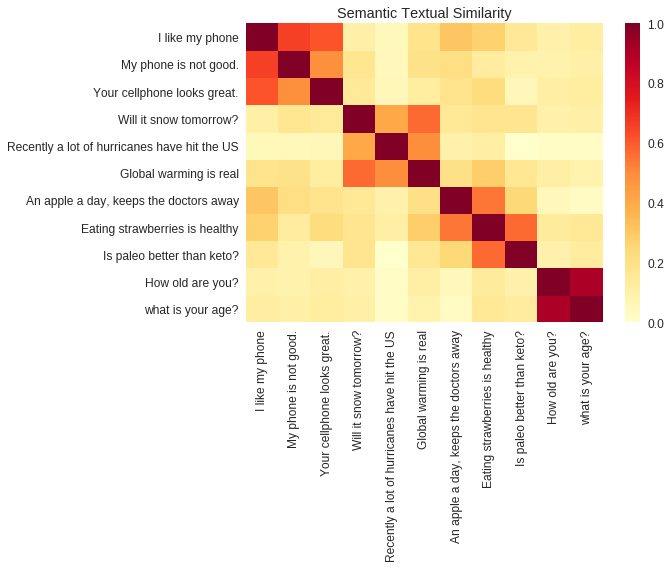

In [8]:
similarity_input_placeholder = tf.placeholder(tf.string, shape=(None))
similarity_message_encodings = embed(similarity_input_placeholder)
with tf.Session() as session:
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  run_and_plot(session, similarity_input_placeholder, messages,
               similarity_message_encodings)

### 2D representation via PCA 

In [0]:
def get_2d_representation(words_list):
    with tf.Session() as session:
        session.run([tf.global_variables_initializer(), tf.tables_initializer()])
        description_embeddings  =  session.run(embed(words_list)) #Generates the sentence embeddings
        
        model = PCA(n_components = 2) # Initializing the PCA object. We use n_components = 2 to help us plot our findings in the 2D space.
        # Apply the fit_transform method of model to grains: pca_features
        pca_features = model.fit_transform(description_embeddings) # Transforms embeddings to vectors of size 2
        # Assign 0th column of pca_features: xs
        xs = pca_features[:,0] #The first component of PCA
        # Assign 1st column of pca_features: ys
        ys = pca_features[:,1] #Second component of PCA
        
        #Next, we'll plot these results
        #fig, ax = plt.subplots()
        fig, ax = plt.subplots(figsize=(8,8)) 
        ax.scatter(xs, ys)        
        for i, txt in enumerate(words_list):
            ax.annotate(txt, (xs[i]+0.03, ys[i]), fontsize=11)

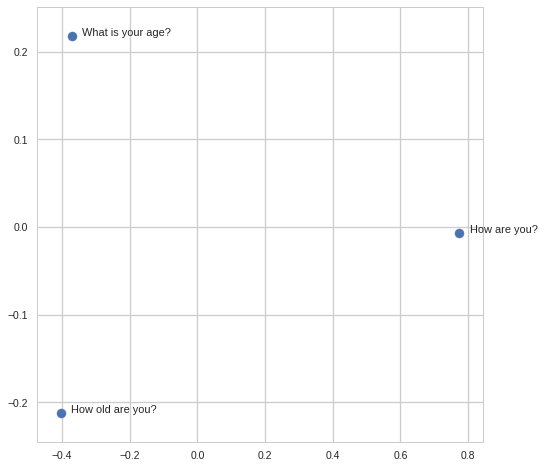

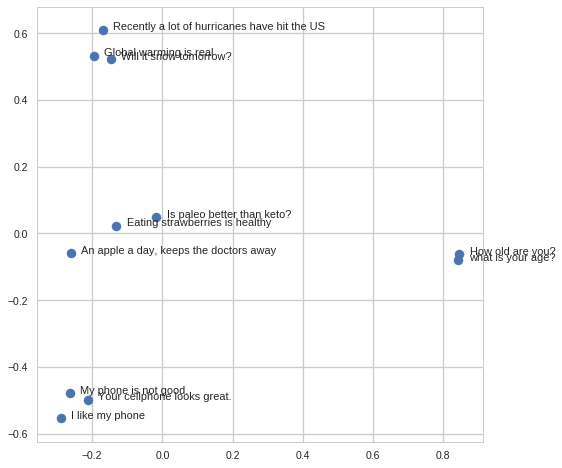

In [23]:
get_2d_representation(sentences_list)
get_2d_representation(messages)

## Evaluate Sentence Embedding

In [19]:
def load_sts_dataset(filename):
  # Loads a subset of the STS dataset into a DataFrame. In particular both
  # sentences and their human rated similarity score.
  sent_pairs = []
  with tf.gfile.GFile(filename, "r") as f:
    for line in f:
      ts = line.strip().split("\t")
      # (sent_1, sent_2, similarity_score)
      sent_pairs.append((ts[5], ts[6], float(ts[4])))
  return pd.DataFrame(sent_pairs, columns=["sent_1", "sent_2", "sim"])


def download_and_load_sts_data():
  sts_dataset = tf.keras.utils.get_file(
      fname="Stsbenchmark.tar.gz",
      origin="http://ixa2.si.ehu.es/stswiki/images/4/48/Stsbenchmark.tar.gz",
      extract=True)

  sts_dev = load_sts_dataset(
      os.path.join(os.path.dirname(sts_dataset), "stsbenchmark", "sts-dev.csv"))
  sts_test = load_sts_dataset(
      os.path.join(
          os.path.dirname(sts_dataset), "stsbenchmark", "sts-test.csv"))

  return sts_dev, sts_test


sts_dev, sts_test = download_and_load_sts_data()
sts_data = sts_dev #@param ["sts_dev", "sts_test"] {type:"raw"}

417792/409630 [==============================] - 3s 7us/step


In [0]:
sts_input1 = tf.placeholder(tf.string, shape=(None))
sts_input2 = tf.placeholder(tf.string, shape=(None))

# For evaluation we use exactly normalized rather than
# approximately normalized.
sts_encode1 = tf.nn.l2_normalize(embed(sts_input1), axis=1)
sts_encode2 = tf.nn.l2_normalize(embed(sts_input2), axis=1)
cosine_similarities = tf.reduce_sum(tf.multiply(sts_encode1, sts_encode2), axis=1)
clip_cosine_similarities = tf.clip_by_value(cosine_similarities, -1.0, 1.0)
sim_scores = 1.0 - tf.acos(clip_cosine_similarities)

In [21]:
text_a = sts_data['sent_1'].tolist()
text_b = sts_data['sent_2'].tolist()
dev_scores = sts_data['sim'].tolist()

def run_sts_benchmark(session):
  """Returns the similarity scores"""
  emba, embb, scores = session.run(
      [sts_encode1, sts_encode2, sim_scores],
      feed_dict={
          sts_input1: text_a,
          sts_input2: text_b
      })
  return scores


with tf.Session() as session:
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  scores = run_sts_benchmark(session)

pearson_correlation = scipy.stats.pearsonr(scores, dev_scores)
print('Pearson correlation coefficient = {0}\np-value = {1}'.format(
    pearson_correlation[0], pearson_correlation[1]))

Pearson correlation coefficient = 0.8016485747067718
p-value = 0.0
